In [21]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%reload_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import sys
sys.path.append('../src')

import cv2
from IPython.display import display_html
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import matplotlib.patches as mpatches
from metadata import metadata
import ome_types
import os
import numpy as np
import pandas as pd
from pathlib import Path
from random import sample
import re
# from sklearn.mixture import GaussianMixture
from scikit_posthocs import posthoc_dunn as phd
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

from utils import list_subdir_filter as lsd

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression as lr
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import minmax_scale


md = metadata()
figures_dir = '/projects/ag-bozek/lunaphore/reports/figures'


all_markers = ['ki67', 'slug', 'ccasp', 'c-myc', 'cell_vim', 'cell_ecad']
conditions  = ['wt_ctr', 'wt_TT', 'ko_ctr', 'ko_TT', 'res_ctr', 'res_TT']
to_analyze = ['ki67_mean', 'slug_mean', 'cell_gfp_mean', 'ccasp_mean', 'c-myc_mean', 'cell_ecad_mean', 'cell_vim_mean']


def get_lower_tri_heatmap(df, name):
    '''
    description: todo
    '''
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = 'viridis'#sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df, mask=mask, cmap=cmap, vmax=1, center=0.5,
            square=True, annot=True, fmt='.4f', linewidths=.5, cbar_kws={"shrink": .5})
    # # save to file
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(figures_dir, name))

    return sns_plot


Load the single cell data for all samples

In [2]:
# with tiff.TiffFile(all_imgs[7]) as ttt:
#     metadata= ttt.ome_metadata

In [3]:
# ome_md = ome_types.from_tiff(all_imgs[7])
# [c.name for c in ome_md.images[0].pixels.channels]

In [44]:
%%time
pickle_files = lsd(md.folders['regionprops'], False, 'A40_')

all_df = []

for f in pickle_files:
    slide_id = re.sub('.*A40_([0-9]+).*', '\\1', f)
    df_ = pd.read_pickle(f)
    # print(slide_id, np.sum(df_.isna().sum()))
    # print(df_.shape)
    df_['slide_id'] = slide_id
    all_df.append(df_)

df_tot = pd.concat(all_df)

colnames = df_tot.columns.values
marker_names = list(md.markers)[3:]
nuclei_names = [f for f in colnames if not re.search('^cell_', f)]
cell_names = [f for f in colnames if re.search('^cell_', f)]

nuclei_lnames = [re.sub('intensity_([a-z]+)-([0-9]+).*', '\\2.\\1', f).split('.') for f in nuclei_names]
cell_lnames = [re.sub('.*intensity_([a-z]+)-([0-9]+).*', '\\2.\\1', f).split('.') for f in cell_names]

renaming_dict = {n:n for n in colnames}

def do_rename(colname):
    if len(colname) == 2:
        return f'{marker_names[int(colname[0])]}_{colname[1]}'
    else:
        return colname[0]

renaming_dict = {
    **{nuclei_names[i]:do_rename(nuclei_lnames[i]) for i in range(len(nuclei_lnames))},
    **{cell_names[i]:f'cell_{do_rename(cell_lnames[i])}' for i in range(len(cell_lnames))}
}

renaming_dict['cell_centroid-0'] = 'cell_centroid-0'
renaming_dict['cell_centroid-1'] = 'cell_centroid-1'

# REMOVE SLIDE 2427 as per Jenny's request!
df_tot = df_tot.rename(columns=renaming_dict).reset_index(drop=True)
df_tot = df_tot.loc[df_tot.slide_id != '2427']
df_tot = df_tot.loc[df_tot.slide_id != '2397']
df_tot = df_tot.loc[df_tot.slide_id != '2294']
df_tot = df_tot.loc[df_tot.slide_id != '2311']

CPU times: user 2.19 s, sys: 1.95 s, total: 4.14 s
Wall time: 4min 39s


In [79]:
%%time
df_clean = df_tot.dropna()
df_clean.loc[df_clean['slide_id'] == '9429', 'slide_id'] = '2429'
df_clean['slide_id'] = df_clean['slide_id'].astype('category')
slide_ids = df_clean.slide_id.unique()

xfile = pd.read_excel(lsd(md.folders['images'], True, 'xls')[0])
xfile['id_code'] = [re.sub('A40.', '', l) for l in xfile.Identification]
xfile = xfile.loc[xfile['id_code'].isin(slide_ids)].sort_values('id_code')
# pd.read_csv()

condition_dict = {xfile.iloc[i]['id_code']:xfile.iloc[i]['Condition'] for i in range(len(xfile))}
df_clean['condition'] = [condition_dict[f] for f in df_clean['slide_id']]
df_clean['condition'] = df_clean['condition'].astype('category').cat.reorder_categories(conditions, ordered=True)
# df_clean['condition'].astype('category')

df_clean = df_clean.groupby('slide_id', group_keys=False, observed=False).apply(
    lambda g: g[g.cell_gfp_mean < g.cell_gfp_mean.quantile(.95)]
)

df_clean = df_clean.sort_values('condition')

conditions = df_clean.condition.unique()

<timed exec>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


CPU times: user 1.36 s, sys: 581 ms, total: 1.94 s
Wall time: 2.11 s


In [80]:
# %%time
# df_copy = df_clean.copy()

In [81]:
# %%time
# df_clean[to_analyze] = df_clean.groupby('slide_id', observed=False)[to_analyze]\
#     .transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# # # for col in replacement.columns:
# #     df_clean[col] = replacement[col]

In [82]:
# not sure we do need all this stuff, but oh well
flierprops = dict(
    marker='.', 
    markerfacecolor='black', 
    alpha=0.6, 
    markersize=4, 
    markeredgecolor='none'
)

meanpointprops = dict(
    marker='.', 
    markerfacecolor='black', 
    markersize=8, 
    markeredgecolor='none'
)

meanlineprops = dict(linewidth=1.5)

medianprops=dict(linewidth = 1.9)

titleargs=dict(
    x=0.037,
    y=1,
    ha='left',
    va='top',
    fontsize=18
)

textargs=dict(
    x=0.05, 
    y=0.95,
    horizontalalignment='left',
    verticalalignment='top', 
    fontsize=16,
    c='black',
    weight='bold'
)

percargs=dict(
    x=0.96, 
    y=0.95,
    horizontalalignment='right',
    verticalalignment='top', 
    fontsize=16,
    c='black',
    weight='normal'
)

In [83]:
# filter_df = df_clean.loc[df_clean['condition'] == conditions[1]]

# for s in filter_df.slide_id.unique():
#     #plt.hist(filter_df.loc[(filter_df.slide_id == s) & (filter_df.gfp_mean < 100), 'gfp_mean'], bins=100, alpha=0.3)
#     ax = filter_df.loc[(filter_df.slide_id == s) & (filter_df.gfp_mean < 100), 'gfp_mean'].plot.density(alpha=0.6)
# ax.set_xlim(-5, 75)

In [84]:
df_clean.ccasp_mean

435490     3.097666
505107     0.221429
505106     5.240304
505104     2.507732
505103     2.560773
             ...   
1584169    5.582405
1584170    6.869806
1584171    5.938472
1584161    6.328811
1588790    6.133609
Name: ccasp_mean, Length: 1246651, dtype: float64

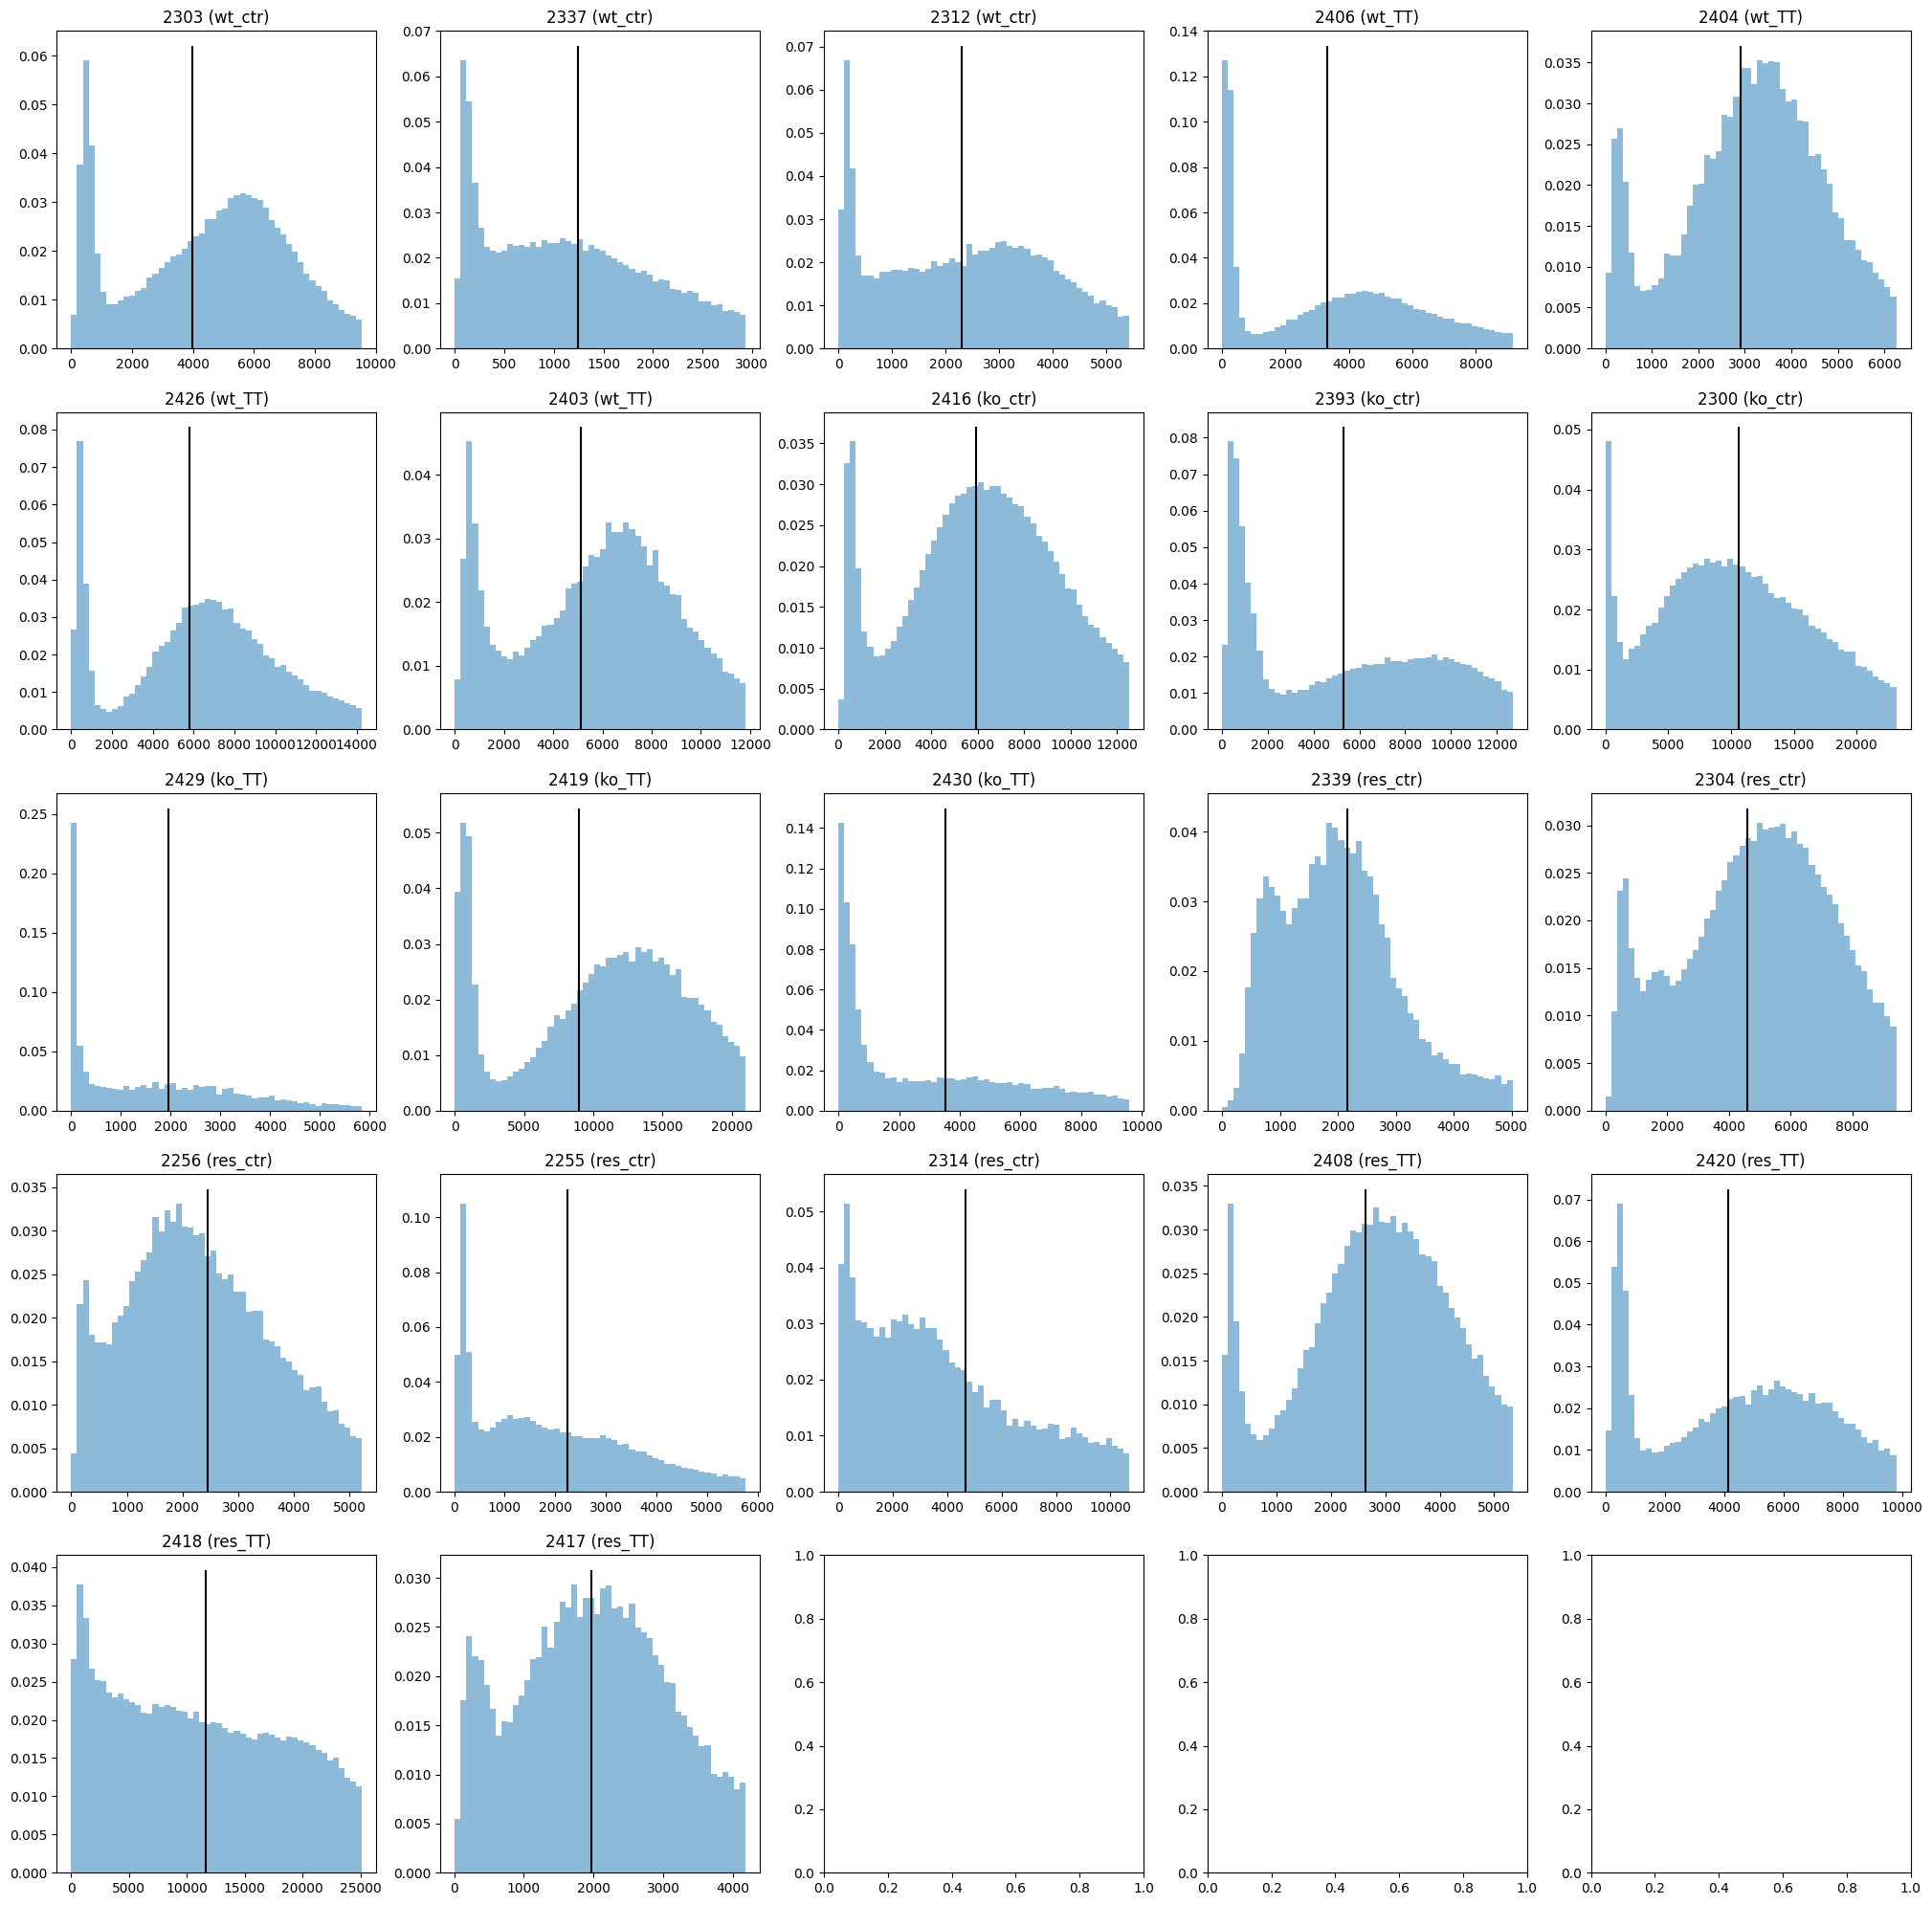

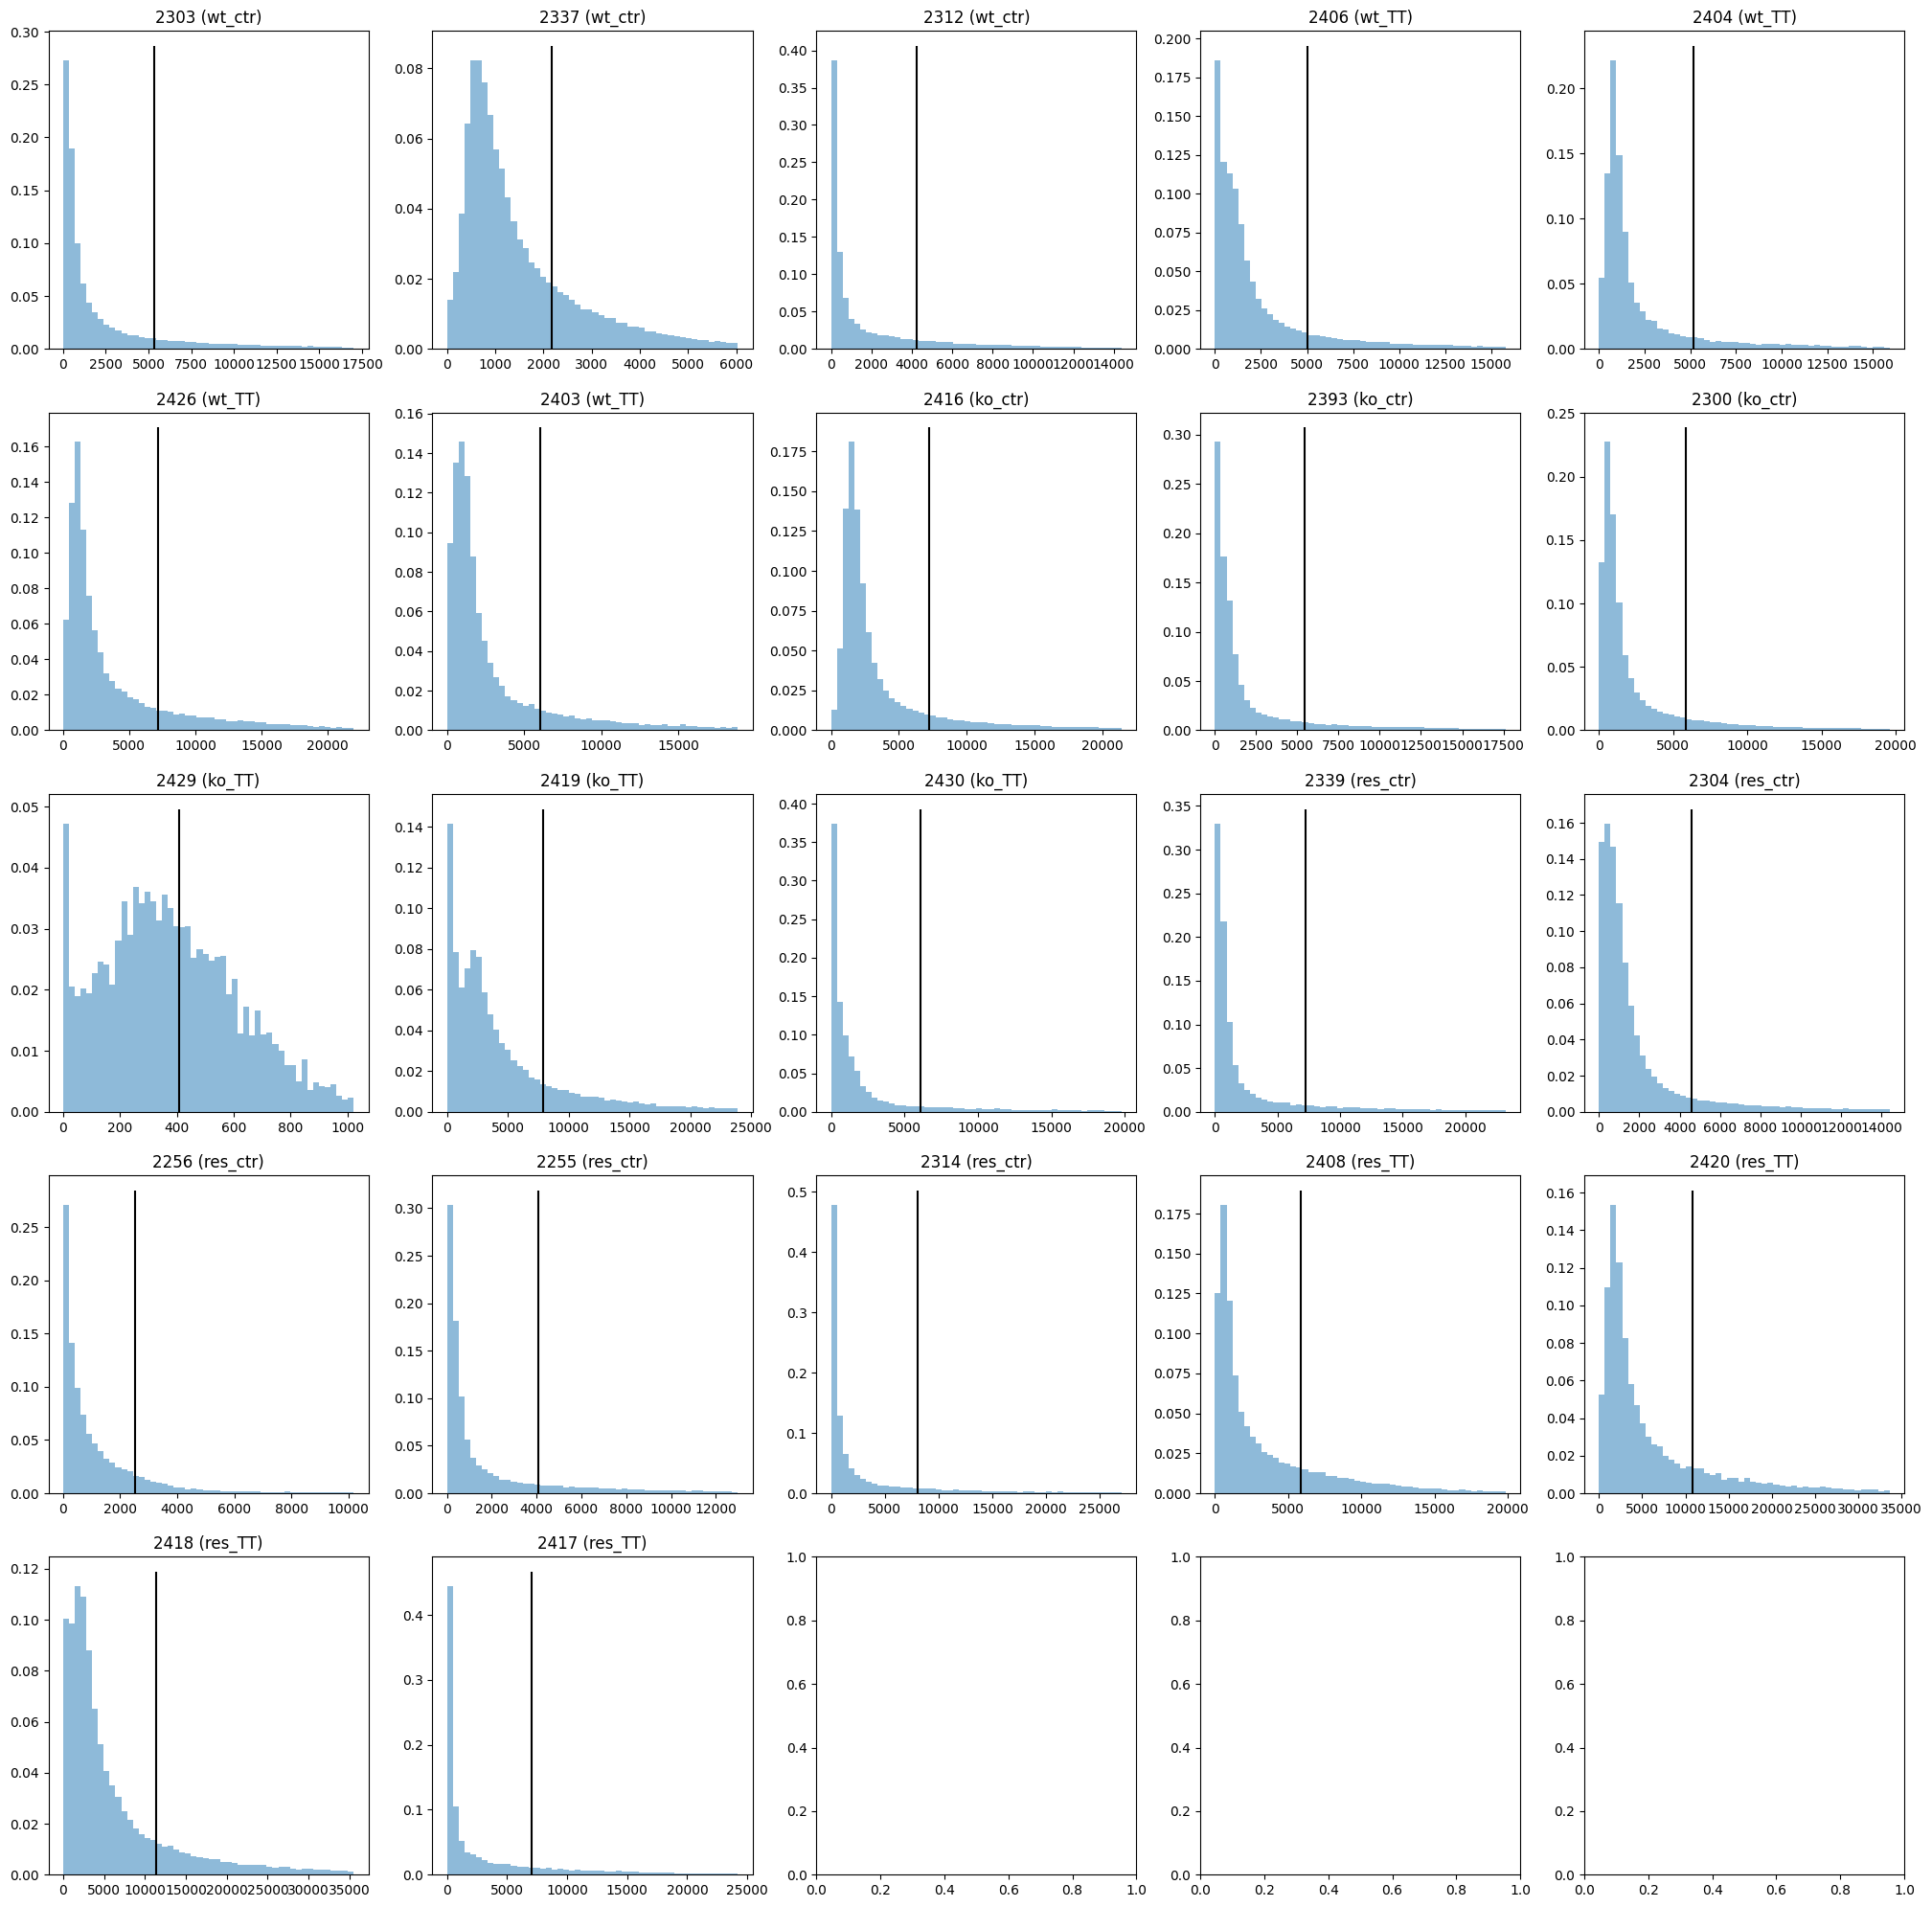

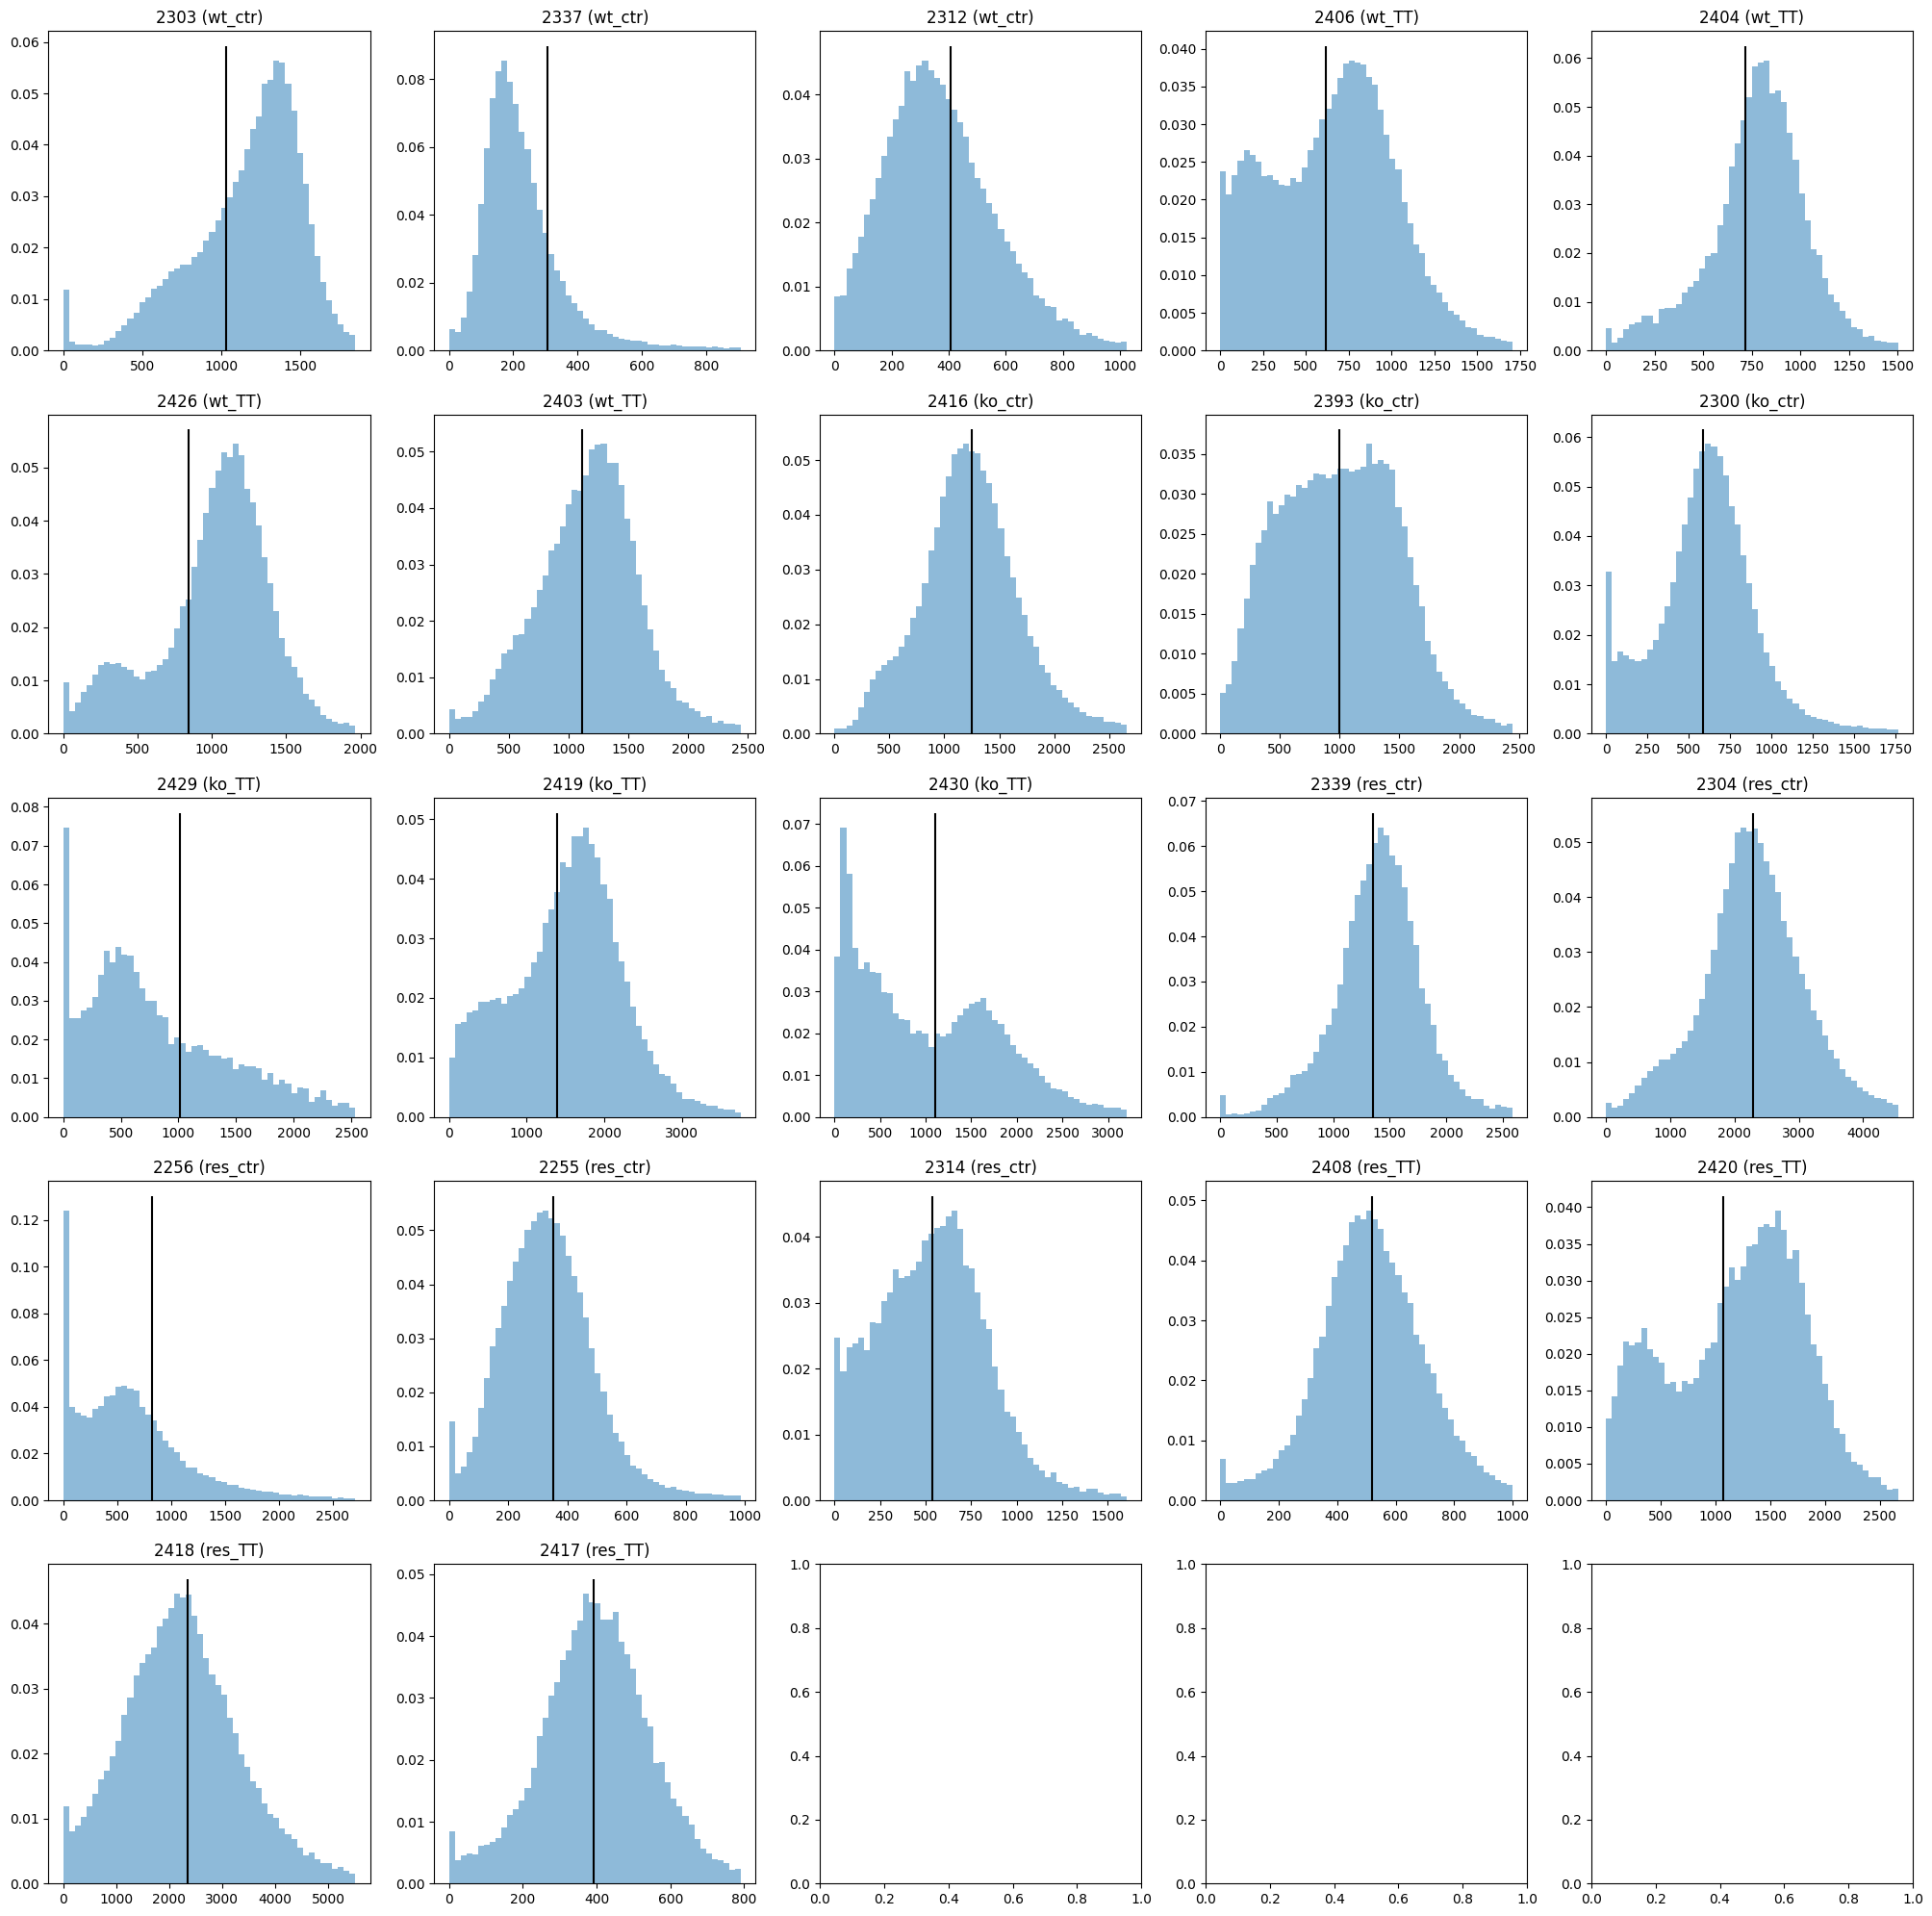

In [85]:
threshold_dict = {}

for bin_marker in ['cell_gfp_mean', 'ki67_mean', 'ccasp_mean']:
    threshold_dict[bin_marker] = {}
    fig, axis = plt.subplots(5,5, figsize=(25, 25))#, sharex=True, sharey=True)
    ax = axis.ravel()
    for i, s_id in enumerate(df_clean.slide_id.unique()):
        pltval = df_clean.loc[df_clean.slide_id == s_id][bin_marker]
        pltval = pltval[pltval < np.quantile(pltval, 0.98)] * 500
        weights = np.ones_like(pltval) / len(pltval)
        t_val, _ = cv2.threshold(np.array(pltval).astype('uint16'), 0, 1, cv2.THRESH_OTSU)
        ax[i].hist(pltval, bins=50, weights=weights, alpha=0.5)
        yy = ax[i].get_ylim()
    
        threshold_dict[bin_marker][s_id] = t_val / 500
        
        ax[i].set_title(f'{s_id} ({condition_dict[s_id]})')
        ax[i].vlines(x=t_val, ymin=0, ymax=yy[-1], color='black')

        # plt.savefig(os.path.join(figures_dir, f'histogram_{bin_marker}_'), dpi=300)
        # ax[i].vlines(x=nt_val, ymin=0, ymax=0.035, color='green')

In [86]:
# gmm = GaussianMixture(n_components=2)
# pltval = df_clean.loc[df_clean.slide_id == '2416'].cell_gfp_mean
# pltval = pltval[pltval < np.quantile(pltval, 0.95)]
# gmm = gmm.fit(X=np.expand_dims(pltval,1))

# # Evaluate GMM
# gmm_x = np.linspace(0,np.ceil(pltval.max()).astype('int'),1000)
# gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))


In [87]:
for bin_marker in ['cell_gfp_mean', 'ki67_mean', 'ccasp_mean']:
    
    positive = []
    for s_id, threshold in threshold_dict[bin_marker].items():
        positive.append(df_clean.loc[df_clean.slide_id == s_id, bin_marker] > threshold)
    
    df_clean.loc[:, f'{bin_marker}_positive'] = pd.concat(positive)
    
df_gfp_positive = df_clean.loc[df_clean.cell_gfp_mean_positive].reset_index()
df_ki67_positive = df_clean.loc[df_clean.ki67_mean_positive].reset_index()
df_ccasp_positive = df_clean.loc[df_clean.ccasp_mean_positive].reset_index()

    
df_gfp_negative = df_clean.loc[~df_clean.cell_gfp_mean_positive].reset_index()

In [88]:
boxplot_dir = os.path.join(figures_dir, 'boxplots')
Path(boxplot_dir).mkdir(exist_ok=True, parents=True)

In [89]:
m_a = []
for amount in ['mean', 'max']:
    for measure in ['slug', 'ki67', 'ccasp', 'c-myc']:
        m_a.append([measure, amount]) 

# conditions = []
# for c in ['wt', 'ko', 'res']:
#     for t in ['TT', 'ctr']:
#         conditions.append(f'{c}_{t}')


# conditions = ['wt_ctr', 'wt_TT', 'ko_ctr', 'ko_TT', 'res_ctr', 'res_TT']

# print(m_a)
# print(conditions)

In [90]:
textargs=dict(
    x=0.05, 
    y=0.95,
    horizontalalignment='left',
    verticalalignment='top', 
    fontsize=10,
    c='black',
    weight='normal'
)


In [ ]:
size_unit = 5
fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 3 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_positive.loc[df_gfp_positive.condition == conditions[i]]
    ax.scatter(dd.cell_vim_mean, dd.cell_ecad_mean, s=0.1, alpha=1, rasterized=True)
    ax.text(
        s= f'{conditions[i]}',
        transform=ax.transAxes,
        **textargs
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
#fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')
plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL.svg'), dpi=300)

In [ ]:
## let's come up with some metric to express this and that


In [ ]:
p=plt.hist(yy.cell_vim_mean, bins=255)

In [ ]:
p=plt.hist(yy.cell_ecad_mean, bins=255)

In [ ]:
yy = [df_clean.loc[df_clean.condition==c, measure] for c in conditions]
x_ = [list(range(len(d))) for d in yy]
y_ = [sorted(d) for d in yy]
dy = [np.diff(y) for y in y_]
ddy = [np.diff(y) for y in dy]

In [ ]:
conditions

In [ ]:
cond_colors = ('indianred', 'gold', 'yellowgreen', 'turquoise', 'mediumblue', 'orchid')
dict_cond_colors = dict(zip(conditions, cond_colors))

In [ ]:
dict_cond_colors

In [ ]:
# def coolplot(data):

for measure in to_analyze:
    
    def rel_length(l, n_remove=0):
        if n_remove:
            l = l[:-n_remove]
        return np.divide(l, len(l))
    
    fig, axes = plt.subplots(1,1, figsize=(10,10), sharex=True)
    patches = []
    for c in conditions:
        yy = df_clean.loc[df_clean.condition==c]

        patches.append(mpatches.Patch(color = dict_cond_colors[c], label=c))
        
        data = yy[measure]
        data = data[data > 0]
        x_ = list(range(len(data)))
        y_ = sorted(data)
        dy = np.diff(y_)
        ddy = np.diff(dy)

    # yy = [df_clean.loc[df_clean.condition==c, measure] for c in conditions]
    # x_ = [list(range(len(d))) for d in yy]
    # y_ = [sorted(d) for d in yy]
    # dy = [np.diff(y) for y in y_]
    # ddy = [np.diff(y) for y in dy]
        
        axes.scatter(
            rel_length(x_), 
            np.log(y_),
            s=0.2,
            c = dict_cond_colors[c]
        )
        axes.set_title(measure)
        # axes.set_xlim(0.7, 1)
        
        # mdy = pd.Series(np.log(dy)).rolling(window=150).mean()#rolling(window=15).mean()
        # axes[1].scatter(
        #     rel_length(list(range(len(mdy[mdy != None])))),
        #     mdy[mdy != None],
        #     #np.log(dy),
        #     s=0.1,
        #     alpha = 0.1,
        #     c = dict_cond_colors[c]
        # )
        
        # axes[2].scatter(
        #     rel_length(x_, 2),
        #     abs(ddy),
        #     s=0.2,
        #     c = dict_cond_colors[c]
        # )

    axes.legend(handles=patches)


In [ ]:
import statsmodels.api as sm

In [ ]:
df_clean.condition.map(dict_cond_colors)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
df_std = df_clean.copy(deep=True)
df_std[to_analyze] = df_std.groupby('slide_id')[to_analyze]\
    .transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
Xpre = df_clean.groupby('condition', observed=True).sample(3_000)
X = Xpre.loc[:, to_analyze]
# pca = PCA(n_components=2)
# X2 = pca.fit(X).transform(X)

In [ ]:
len(X2)

In [ ]:
plt.scatter(X2[:,0], X2[:,1], s=0.2, alpha=0.1, c=Xpre.condition.map(dict_cond_colors))
plt.xlim(-50, 50)
plt.ylim(-25, 75)

In [ ]:
tsne = TSNE(n_components=2, perplexity=45, verbose=True, random_state=221, n_jobs=20)


In [ ]:
X

In [ ]:
%%time
tsne = TSNE(n_components=2, perplexity=45, verbose=True, random_state=221, n_jobs=-1)
df_tsne_coords = tsne.fit_transform(X) 

In [ ]:
df_tsne_coords[:, 0]

In [ ]:
plt.scatter(
    df_tsne_coords[:, 0],
    df_tsne_coords[:, 1],
    c=Xpre['condition'].map(dict_cond_colors),
    s=0.1
)

In [ ]:
plt.hist2d(
        yy.cell_vim_mean, 
        yy.cell_ecad_mean, 
        bins=80,  
        range=[[0, 40], [0, 40]],
        # norm=plt_colors.LogNorm(),
    )

In [ ]:
%%time
linreg = lr(n_jobs=-1)

linreg.fit(dd.cell_vim_mean.values.reshape(-1,1), dd.cell_ecad_mean.values.reshape(-1,1))

In [ ]:
%time
m, b = np.polyfit(dd.cell_vim_mean.values, dd.cell_ecad_mean.values, deg=1)
plt.axline(xy1=(0, b), slope=m, c='white')

In [ ]:
np.polyfit(dd.cell_vim_mean.values, dd.cell_ecad_mean.values, deg=1)

In [ ]:
linreg = lr(n_jobs=-1, fit_intercept=False).fit(dd.cell_vim_mean.values.reshape(-1,1), dd.cell_ecad_mean.values.reshape(-1,1))

In [ ]:
linreg.coef_.flatten()[0]

In [ ]:
np.quantile(dd.cell_vim_mean, [0.05, 0.95])

In [ ]:
plt.hist(dd.cell_vim_mean[dd.cell_vim_mean < 40].values, bins=100)

In [ ]:
def mask_x(x):
    return np.ma.masked_outside(x, *np.quantile(x, [0.05, 0.95]))

vm = mask_x(dd.cell_vim_mean)
em = mask_x(dd.cell_ecad_mean)

In [ ]:
np.sum(vm.mask)

In [ ]:
np.sum(vm.mask & em.mask)

In [ ]:
dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.05, 0.95])) &\
dd.cell_ecad_mean.between(*np.quantile(dd.cell_ecad_mean, [0.05, 0.95]))
dd = dd.loc[dd.keep, ['cell_vim_mean', 'cell_ecad_mean']]

In [ ]:
vm

In [ ]:
plt.scatter(vm, em)

/tmp/ipykernel_229474/3838151471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.01, 0.95])) &\
/tmp/ipykernel_229474/3838151471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.01, 0.95])) &\
/tmp/ipykernel_229474/3838151471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

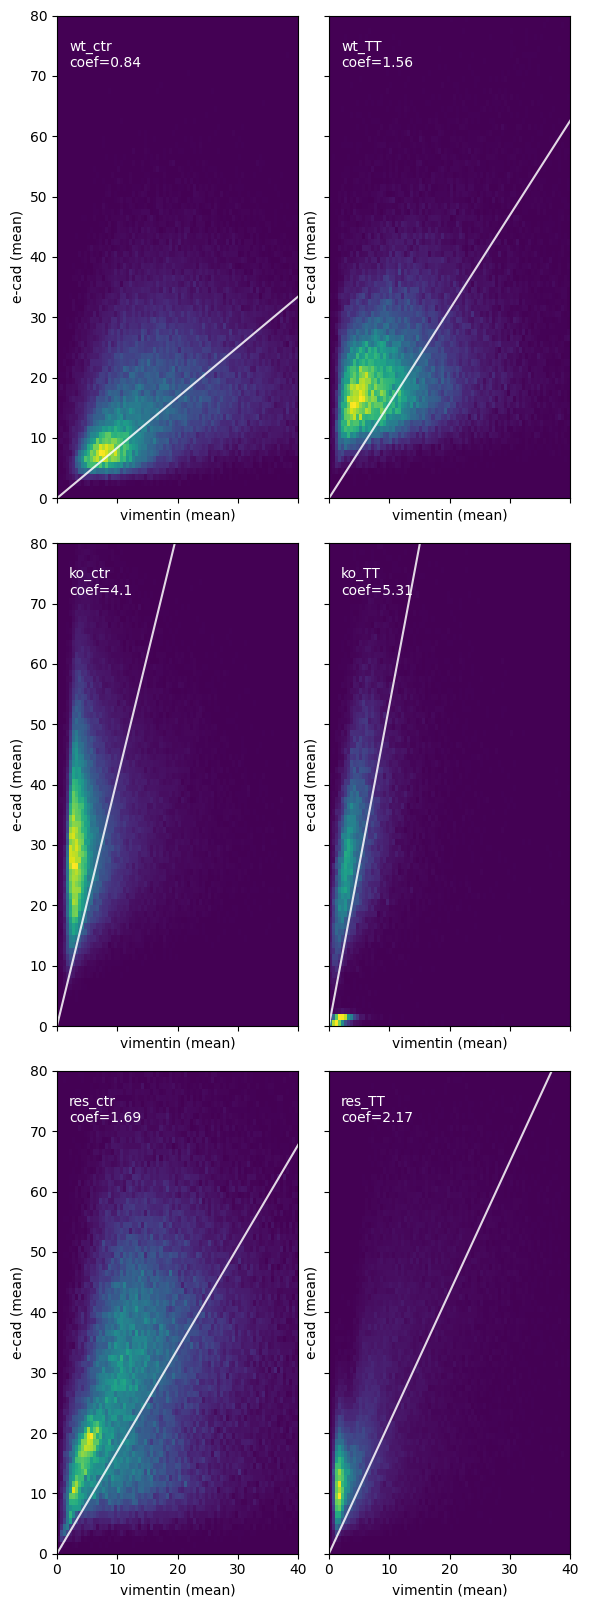

In [95]:
targs2 = textargs
targs2['c'] = 'white'

size_unit = 3

cond_slope = {}

fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 5.5 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_positive.loc[df_gfp_positive.condition == conditions[i]]
    dd.loc[:, 'keep'] = dd.cell_vim_mean.between(*np.quantile(dd.cell_vim_mean, [0.01, 0.95])) &\
        dd.cell_ecad_mean.between(*np.quantile(dd.cell_ecad_mean, [0.01, 0.95]))
    ddf = dd.loc[dd.keep, ['cell_vim_mean', 'cell_ecad_mean']]
    
    linreg = lr(n_jobs=-1, fit_intercept=False)\
        .fit(ddf.cell_vim_mean.values.reshape(-1,1), ddf.cell_ecad_mean.values.reshape(-1,1))
    m = linreg.coef_.flatten()[0]

    cond_slope[conditions[i]] = m
    
    ax.hist2d(
        dd.cell_vim_mean, 
        dd.cell_ecad_mean, 
        bins=80,  
        range=[[0, 40], [0, 80]],
        # norm=plt_colors.LogNorm(),
    )

    ax.axline(xy1=(0, 0), slope=m, c='white', alpha=0.85)
    ax.text(
        s= f'{conditions[i]}\ncoef={np.round(m, 2)}',
        transform=ax.transAxes,
        **targs2,
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
    ax.axis('scaled')
    
fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')

# plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL_heatmap.png'))

In [96]:
cond_slope

{'wt_ctr': 0.8363224203174143,
 'wt_TT': 1.5647885059520912,
 'ko_ctr': 4.095878166285034,
 'ko_TT': 5.3060284268143425,
 'res_ctr': 1.6945769955039751,
 'res_TT': 2.1668144243866174}

In [107]:
cond_mse = {}

for i in range(len(conditions)):
    
    c = conditions[i]
    
    dd = df_clean.loc[df_clean.condition == c, ['cell_vim_mean', 'cell_ecad_mean']]
    m = np.mean((dd.cell_vim_mean * cond_slope[c] - dd.cell_ecad_mean) ** 2)

    cond_mse[c] = m

In [108]:
cond_mse_crossed = {}

for i in range(len(conditions))[::2]:
    print(i)
    c1 = conditions[i]
    c2 = conditions[i+1]
    
    dd1 = df_clean.loc[df_clean.condition == c1, ['cell_vim_mean', 'cell_ecad_mean']]
    m1 = np.mean((dd.cell_vim_mean * cond_slope[c2] - dd.cell_ecad_mean) ** 2)

    dd2 = df_clean.loc[df_clean.condition == c2, ['cell_vim_mean', 'cell_ecad_mean']]
    m2 = np.mean((dd.cell_vim_mean * cond_slope[c1] - dd.cell_ecad_mean) ** 2)

    cond_mse_crossed[c1] = m1
    cond_mse_crossed[c2] = m2

0
2
4


In [109]:
cond_mse

{'wt_ctr': 99.2436620992617,
 'wt_TT': 146.9359861672078,
 'ko_ctr': 580.2217832639325,
 'ko_TT': 235.23749452004708,
 'res_ctr': 368.6282846906373,
 'res_TT': 288.095254906489}

In [110]:
cond_mse_crossed

{'wt_ctr': 232.97940302619233,
 'wt_TT': 308.5734162031978,
 'ko_ctr': 2299.6446639425926,
 'ko_TT': 1181.4944602226137,
 'res_ctr': 288.095254906489,
 'res_TT': 235.8638330969361}

In [113]:
for c in conditions:
    print( c, round(cond_mse_crossed[c] / cond_mse[c],2))

wt_ctr 2.35
wt_TT 2.1
ko_ctr 3.96
ko_TT 5.02
res_ctr 0.78
res_TT 0.82


In [ ]:
targs2 = textargs
targs2['c'] = 'white'

size_unit = 3

fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 4 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_negative.loc[df_gfp_negative.condition == conditions[i]]
    
    ax.hist2d(
        dd.cell_vim_mean, 
        dd.cell_ecad_mean, 
        bins=80,  
        range=[[0, 60], [0, 90]],
        # norm=plt_colors.LogNorm(),
    )

    ax.text(
        s= f'{conditions[i]}',
        transform=ax.transAxes,
        **targs2,
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')
plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL_NEGATIVE_heatmap.png'))

In [ ]:
size_unit = 3

fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 4 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_positive.loc[df_gfp_positive.condition == conditions[i]]
    
    ax.hist2d(
        dd.cell_vim_mean, 
        dd.cell_ecad_mean, 
        bins=80,  
        range=[[0, 20], [0, 30]],
        # norm=plt_colors.LogNorm(),
    )

    ax.text(
        s= f'{conditions[i]}',
        transform=ax.transAxes,
        **targs2,
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')
plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL_heatmap_origin_zoom.png'))

In [ ]:
size_unit = 3

fig, axes = plt.subplots(3, 2, figsize=(2 * size_unit, 4 * size_unit), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    dd = df_gfp_negative.loc[df_gfp_negative.condition == conditions[i]]
    
    ax.hist2d(
        dd.cell_vim_mean, 
        dd.cell_ecad_mean, 
        bins=80,  
        range=[[0, 20], [0, 30]],
        # norm=plt_colors.LogNorm(),
    )

    ax.text(
        s= f'{conditions[i]}',
        transform=ax.transAxes,
        **targs2,
        )
    ax.set_xlabel('vimentin (mean)')
    ax.set_ylabel('e-cad (mean)')
fig.tight_layout(rect=[0.025, 0.02, 1, 1])
# fig.supxlabel('vimentin (mean)')
# fig.supylabel('ecad (mean)')
plt.savefig(os.path.join(figures_dir, 'vimentin_ecad_correlation_CELL_NEGATIVE_heatmap_origin_zoom.png'))

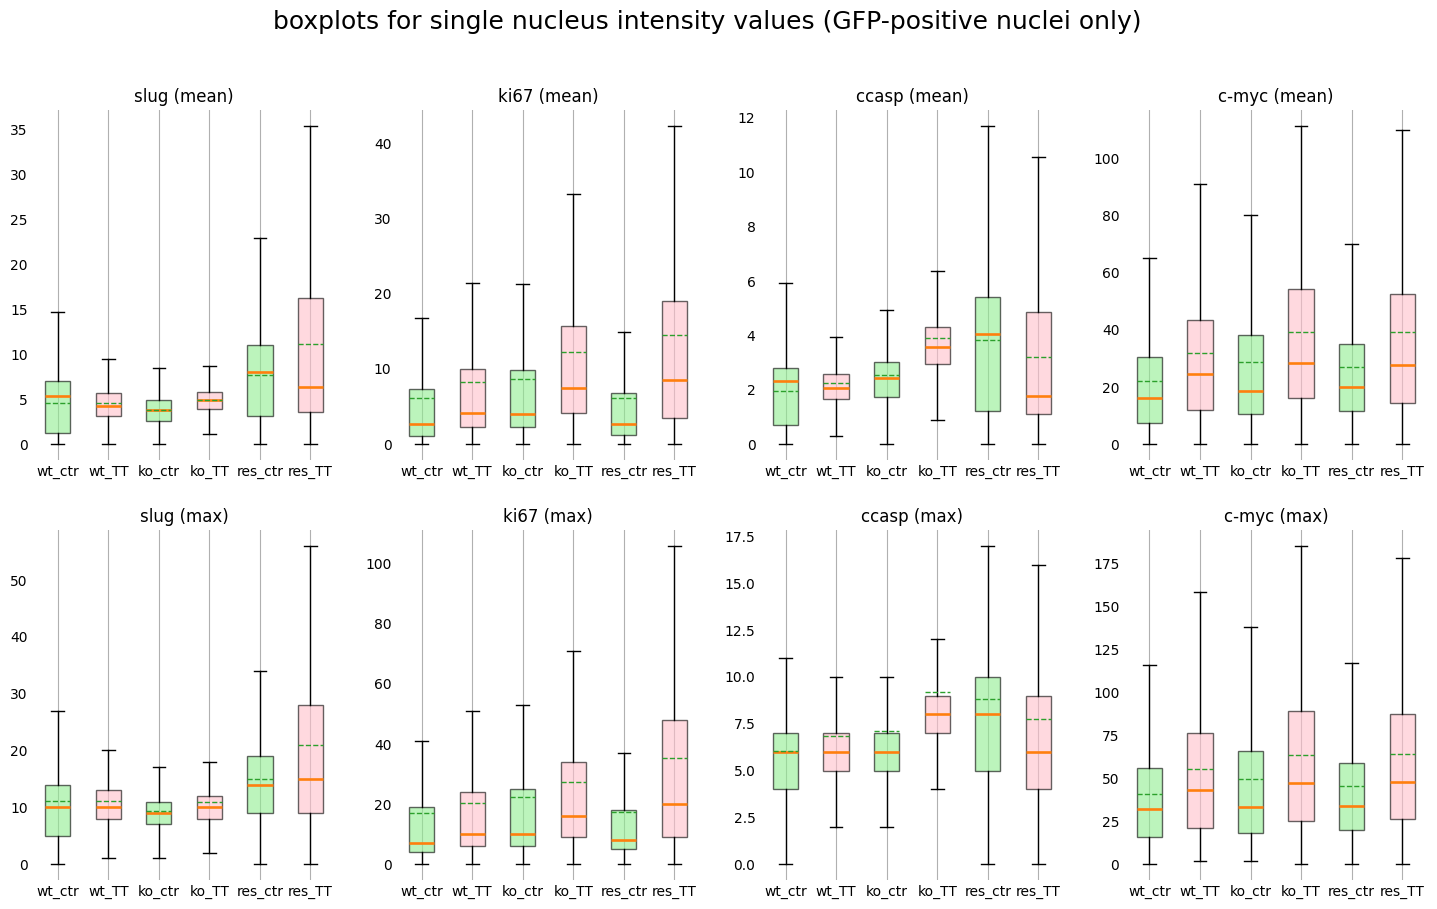

In [114]:
colors = ['lightgreen', 'pink'] * 3

fig, axes = plt.subplots(2,4, figsize=(18,10))
for i, ax in enumerate(axes.ravel()):
    m, a = m_a[i]
    ddict = {}
    
    for c in conditions:
        if c in df_gfp_positive.condition.unique():
            ddict[c] = df_gfp_positive.loc[df_gfp_positive.condition == c, f'{m}_{a}'].values
        
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{m} ({a})')

    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single nucleus intensity values (GFP-positive nuclei only)', fontsize=18)

plt.savefig(os.path.join(boxplot_dir, f'positive_boxplots.png'))

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(18,10))
for i, ax in enumerate(axes.ravel()):
    m, a = m_a[i]
    ddict = {}
    
    for c in conditions:
        ddict[c] = df_clean.loc[df_clean.condition == c, f'{m}_{a}'].values
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{m} ({a})')
    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single nucleus intensity values (all nuclei)', fontsize=18)

plt.savefig(os.path.join(boxplot_dir, f'all_boxplots.svg'))

In [ ]:
df_gfp_positive.columns


In [ ]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
for i, ax in enumerate(axes.ravel()):
    ddict = {}
    
    for c in conditions:
        ddict[c] = df_gfp_positive.loc[df_gfp_positive.condition == c, f'{all_markers[i]}_mean'].values
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{all_markers[i]}')
    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single nucleus intensity values', fontsize=18)

plt.savefig(os.path.join(boxplot_dir, f'all_markers_mean_boxplots.svg'))

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(18,10))
boxplot_dict = {}
for i, ax in enumerate(axes.ravel()):
    m, a = m_a[i]
    ddict = {}
    
    for c in conditions:
        ddict[c] = df_clean.loc[df_clean.condition == c, f'{m}_mean'].values
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    boxplot_dict[m] = {key:boxplot1[key] for key in [k for k in boxplot1.keys() if k != 'fliers']}
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{m} ({a})')
    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single nucleus')


In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def get_whiskers(boxplot_dict):
    return np.reshape([i.get_ydata()[1] for i in boxplot_dict['whiskers']], (-1,2))

def get_medians(boxplot_dict):
    return [[i.get_ydata()[1]] for i in boxplot_dict['medians']]

def get_box_quantiles(boxplot_dict):
    return [sorted(list(set(i._path._vertices[:, -1]))) for i in boxplot_dict['boxes']]

def get_data(bd):
    return [get_whiskers(bd), get_medians(bd), get_box_quantiles(bd)]

In [ ]:
bp_coords = {}
for marker in boxplot_dict.keys():

    bpd = get_data(boxplot_dict[marker])
    
    fin = {}
    for j in range(6):
        fin[conditions[j]] = sorted(flatten([np.round(i[j], 2) for i in bpd]))
    
    bp_coords[marker] = fin

bp_coords

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
for i, ax in enumerate(axes.ravel()):
    ddict = {}
    
    for c in conditions:
        ddict[c] = df_gfp_positive.loc[df_gfp_positive.condition == c, f'{all_markers[i]}_mean'].values
    boxplot1 = ax.boxplot(
        ddict.values(), 
        patch_artist=True,
        showmeans=True,
        meanline=True,
        medianprops=medianprops,
        showfliers=False
    )
    ax.set_xticklabels(ddict.keys())
    
    for box, color in zip(boxplot1['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
        box.set_edgecolor('black')

    ax.set_title(f'{all_markers[i]}')
    ax.set_frame_on(False)
    ax.xaxis.grid()
    ax.tick_params(length=0)

fig.suptitle('boxplots for single intensity values (GFP positive only)', fontsize=18)

plt.savefig(os.path.join(boxplot_dir, f'all_markers_gfp_pos_mean_boxplots.svg'))

### Correlation table between all variables (mean)

In [ ]:
for g in slide_ids:
    corr = df_tot.loc[df_tot.slide_id == g, to_analyze].corr()
    corr.columns = [re.sub('_mean', '', c) for c in corr.columns]   
    corr.index = [re.sub('_mean', '', c) for c in corr.index]    

    corr_styler = (corr).style\
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)\
    .format(precision=2)\
    .set_caption(f'{g} ({condition_dict[g]})')\
    ._repr_html_()

    display_html(corr_styler, raw=True)


## Heatmaps for individual samples

### Marker intensity

In [ ]:
for marker in all_markers:
    fig, axes = plt.subplots(5,5, figsize=(15,15), sharex=True, sharey=True)
    ax = axes.ravel()
    norm_value = df_tot[f'{marker}_mean'].quantile(0.97)
    for i, slide in enumerate(slide_ids.categories):
        dd = df_clean.loc[df_clean.slide_id == slide, [f'{marker}_mean', 'centroid-0', 'centroid-1']]
        ax[i].scatter(
            dd['centroid-0'], 
            dd['centroid-1'], 
            s=0.6, 
            c=np.clip(dd[f'{marker}_mean']/norm_value, 0, 1),
            rasterized=True
        )
        ax[i].set_title(f'{slide} ({condition_dict[slide]})')
    for a in ax:
        a.axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, f'spatial_expression_{marker}.svg'), dpi=300)
    plt.close()

### Heatmap for positive GFP cells

In [ ]:
cdict = {True: 'gold', False: 'indigo'}

fig, axes = plt.subplots(5,5, figsize=(15,15), sharex=True, sharey=True)
ax = axes.ravel()
for i, slide in enumerate(slide_ids.categories):
    dd = df_clean.loc[df_clean.slide_id == slide, ['cell_gfp_mean_positive', 'centroid-0', 'centroid-1']]
    n_pos = dd.cell_gfp_mean_positive.sum()
    n_neg = len(dd) - n_pos
    
    ax[i].scatter(
        dd['centroid-0'], 
        dd['centroid-1'], 
        s=0.6, 
        c=dd['cell_gfp_mean_positive'].map(cdict),
        rasterized=True
    )
    ax[i].set_title(f'{slide} ({condition_dict[slide]} - {round(100*n_pos/(n_pos+n_neg),1)}%)')
for a in ax:
    a.axis('off')
    
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, f'spatial_POSITIVE.svg'), dpi=300)

## barplots for % of positive cells for...

In [ ]:
for marker in ['cell_gfp_mean', 'ki67_mean', 'ccasp_mean']:

    slide_dict = {d:[] for d in conditions}#sorted(df_clean.condition.unique())}
    slide_result = []
    for s in sorted(df_clean.slide_id.unique()):
        
        dd = df_clean.loc[df_clean.slide_id == s]
        cc = dd.condition.unique()[0]
        slide_dict[cc].append(float(dd[f'{marker}_positive'].sum()/len(dd)))
        slide_result.append([s, float(dd[f'{marker}_positive'].sum()/len(dd)), cc])
    
    # plt.figure(figsize=(16,4))
    # plt.bar([r[0] for r in slide_result], [r[1] for r in slide_result])
    # plt.ylim(0, .8)
    # plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_slide.svg'), dpi=300)
    
    result = {}
    for c in conditions:
        
        dd = df_clean.loc[df_clean.condition == c]
        result[c] = float(dd[f'{marker}_positive'].sum()/len(dd))
    
    plt.figure(figsize=(8,4))
    plt.bar(conditions, [result[c] for c in conditions], color='orange')
    plt.scatter([r[2] for r in slide_result], [r[1] for r in slide_result], marker='_', s=700, c='indigo')
    plt.ylim(0, .8)
    plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_category.svg'), dpi=300)


    plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_category_simple.svg'), dpi=300)


/tmp/ipykernel_229474/288442152.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_mean = df_clean.groupby(['slide_id', 'condition']).mean().groupby('condition').mean()[['cell_gfp_mean_positive',  'ki67_mean_positive', 	'ccasp_mean_positive']]
/tmp/ipykernel_229474/288442152.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_mean = df_clean.groupby(['slide_id', 'condition']).mean().groupby('condition').mean()[['cell_gfp_mean_positive',  'ki67_mean_positive', 	'ccasp_mean_positive']]


NameError: name 'slide_result' is not defined

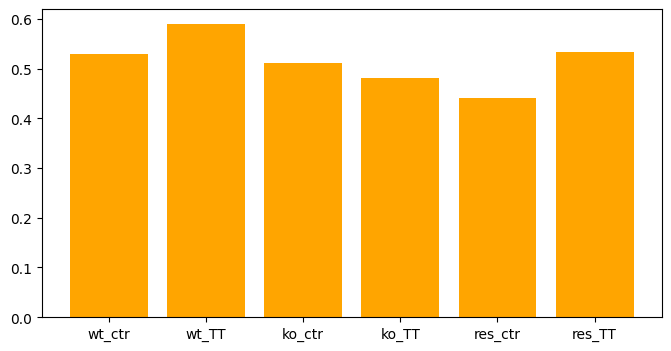

In [115]:
grouped_mean = df_clean.groupby(['slide_id', 'condition']).mean().groupby('condition').mean()[['cell_gfp_mean_positive',  'ki67_mean_positive', 	'ccasp_mean_positive']]

for marker in ['cell_gfp_mean']:#, 'ki67_mean', 'ccasp_mean']:

    plt.figure(figsize=(8,4))
    plt.bar(grouped_mean.index, grouped_mean.loc[:, 'cell_gfp_mean_positive'], color='orange')    
    plt.scatter([r[2] for r in slide_result], [r[1] for r in slide_result], marker='_', s=700, c='indigo')
    plt.ylim(0, .8)
    plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_category_method2.svg'), dpi=300)

    plt.savefig(os.path.join(figures_dir, f'percentage_{marker}+_category_simple_method2.svg'), dpi=300)


In [ ]:
result = []
for s in conditions:
    
    dd = df_clean.loc[df_clean.condition == s]
    #cc = dd.condition.unique()[0]
    #slide_dict[cc].append(float(dd.cell_gfp_mean_positive.sum()/len(dd)))
    result.append([s, len(dd)])

plt.figure(figsize=(8,4))
plt.bar([r[0] for r in result], [r[1]/10**3 for r in result])
plt.savefig(os.path.join(figures_dir, 'absolute_n_cells_category_thousands.svg'), dpi=300)


In [ ]:
result = []
for s in sorted(df_clean.slide_id.unique()):
    
    dd = df_clean.loc[df_clean.slide_id == s]
    #cc = dd.condition.unique()[0]
    #slide_dict[cc].append(float(dd.cell_gfp_mean_positive.sum()/len(dd)))
    result.append([s, len(dd)])

plt.figure(figsize=(16,4))
plt.bar([r[0] for r in result], [r[1]/10**3 for r in result])
plt.savefig(os.path.join(figures_dir, 'absolute_n_cells_sample_thousands.svg'), dpi=300)


In [ ]:
def MWU(cond1, cond2, measure, sample_size=None):

    s1 = df_clean.loc[df_clean.condition == cond1][measure]
    s2 = df_clean.loc[df_clean.condition == cond2][measure]

    if sample_size != None:
        s1 = sample(list(s1), sample_size)
        s2 = sample(list(s2), sample_size)
        
    
    _res = ss.mannwhitneyu(x=s1, y=s2)
    return {'r':_res[0], 'p': round(_res[1], 5)}

In [ ]:
MWU('ko_TT', 'ko_ctr', 'ki67_mean', 10_000)

In [ ]:
mwu_res = dict()

group1 = ['ko', 'res', 'wt']
group2 = ['TT', 'ctr']

for g in group1:
    
    mwu_res[g] = {}

    for meas in all_markers:
        meas = f'{meas}_mean'
        mwu_res[g][meas] = MWU(f'{g}_TT', f'{g}_ctr', meas, 1_000)

mwu_res

In [ ]:
kk_samples = []
for c in conditions:
    kk_samples.append(df_clean.loc[df_clean.condition == c]['ki67_mean'].values)

In [ ]:
ss.kruskal(*kk_samples)

In [ ]:
for measure in to_analyze:

    p_result = phd(
        a=df_clean,
        val_col=measure, 
        group_col='condition'
    )

    get_lower_tri_heatmap(p_result, f'dunn_result_single_{measure}.png')
    
    res_maps = []
    for i in tqdm(range(50)):
        res_maps.append(
            phd(
                a=df_clean.groupby('condition', observed=True).sample(50_000), 
                val_col=measure, 
                group_col='condition'
            )
        )
        #get_lower_tri_heatmap(dunn_res)
    
    get_lower_tri_heatmap(
        pd.concat(res_maps).groupby(level=0, observed=True).mean(),
        f'dunn_result_average_{measure}.png'
    )